In [1]:
%%capture
!pip install diffusers
!pip install transformers scipy ftfy accelerate
!pip install stable_diffusion_videos

In [ ]:
connect_google_drive = True #@param {type:"boolean"}

if connect_google_drive:
    from google.colab import drive

    drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                               torch_dtype=torch.float16,
                                               safety_checker=None
                                               )  


pipe = pipe.to("cuda")

from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid



Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
# # https://huggingface.co/docs/diffusers/using-diffusers/reusing_seeds

prompt = "rolling dunes on an alien planet at night vivid colors cartoon evil red sinister"

# generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(4)]

# images = pipe(prompt, generator=generator, num_images_per_prompt=4).images

# image_grid(images, rows=2, cols=2)

In [2]:
import pandas

In [ ]:
num_images = 3
width = 512
height = 512

device = "cuda"

prompt = "rolling dunes on an alien planet at night vivid colors cartoon evil red sinister"


generator = torch.Generator(device=device)

latents = None
seeds = []
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    
    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))
    
# latents should have shape (4, 4, 64, 64) in this case
latents.shape

torch.Size([3, 4, 64, 64])

In [ ]:
# prompt = "rolling dunes on an alien planet at night vivid colors cartoon evil red sinister"
# prompt = "a cat wearing a hat"
# prompt ="inspired by David A. Hardy, digital landscape art, as a tarot card, alien mountains, glowing green rocks, drawfolio, inspired by Władysław Czachórski, shooting star in background, flowing lines, inspired by Béla Iványi-Grünwald"
# prompt = "a foggy view of a bridge in a fantasy overgrown world, anamorphic, official artwork, alien forest in background, with ethereal light, from a 2 0 1 9 sci fi 8 k movie, manicured garden of eden, by James C. Christensen, soft morning light. hyperrealism, award winning scifi art, nature futurism"
prompt = "descending deep into a cave, red lava on the walls, alice in wonderland movie animation"

In [ ]:


with torch.autocast("cuda"):
    images = pipe(
        [prompt] * num_images,
        guidance_scale=7.5,
        latents = latents,
    ).images

  0%|          | 0/50 [00:00<?, ?it/s]

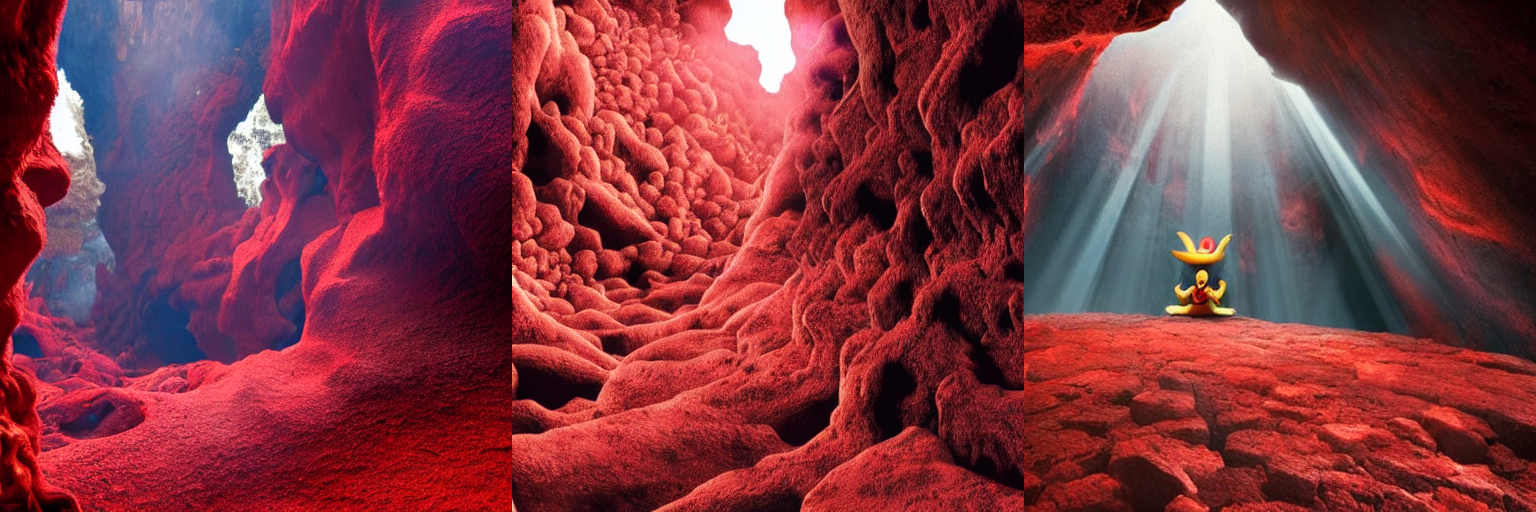

In [ ]:
image_grid(images, 1, 3)

In [ ]:
seeds

[1156934946634882, 4866412378884770, 4940561922459094]

In [ ]:
# seed = seeds[0]  
seed = 7905703042213145  

generator.manual_seed(seed)

latent_choose = torch.randn(
    (1, pipe.unet.in_channels, height // 8, width // 8),
    generator = generator,
    device = device
)

# (latent_choose.squeeze() == latents[1]).all()

seed

7905703042213145

In [ ]:
import numpy as np
import os

output_dir = '/content/gdrive/MyDrive/stable_diffusion_images/latent_noise/{}'.format(seed)

if not os.path.exists(output_dir): os.makedirs(output_dir)


# latent_shifts = np.random.rand(1)*0.01
latent_shifts = np.linspace(0, 0.07, 69)

# latents_shifted = torch.cat([latent_choose + shift for shift in latent_shifts])
# latents_shifted.shape
latent_shifts

array([0.        , 0.00102941, 0.00205882, 0.00308824, 0.00411765,
       0.00514706, 0.00617647, 0.00720588, 0.00823529, 0.00926471,
       0.01029412, 0.01132353, 0.01235294, 0.01338235, 0.01441176,
       0.01544118, 0.01647059, 0.0175    , 0.01852941, 0.01955882,
       0.02058824, 0.02161765, 0.02264706, 0.02367647, 0.02470588,
       0.02573529, 0.02676471, 0.02779412, 0.02882353, 0.02985294,
       0.03088235, 0.03191176, 0.03294118, 0.03397059, 0.035     ,
       0.03602941, 0.03705882, 0.03808824, 0.03911765, 0.04014706,
       0.04117647, 0.04220588, 0.04323529, 0.04426471, 0.04529412,
       0.04632353, 0.04735294, 0.04838235, 0.04941176, 0.05044118,
       0.05147059, 0.0525    , 0.05352941, 0.05455882, 0.05558824,
       0.05661765, 0.05764706, 0.05867647, 0.05970588, 0.06073529,
       0.06176471, 0.06279412, 0.06382353, 0.06485294, 0.06588235,
       0.06691176, 0.06794118, 0.06897059, 0.07      ])

In [ ]:
for i,latent_shift in enumerate(latent_shifts):

  latents_shifted = latent_choose + latent_shift

  with torch.autocast("cuda"):
      images = pipe(
          [prompt] * len(latents_shifted),
          guidance_scale=7.5,
          latents = latents_shifted,
      )

  output_image = images.images[0]

  # for i, image in enumerate(images.images):
  output_image.save(output_dir + '/test_{0:04d}.png'.format(i))


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# image_grid(images.images, 1,1 )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from stable_diffusion_videos import make_video_pyav

make_video_pyav(output_dir, 
                output_filepath='/content/gdrive/MyDrive/stable_diffusion_images/latent_noise/{}.mp4'.format(seed),
                fps=10
                )



video_path